Test data distribution

In [1]:
import numpy as np
import torch
from data.dataset import DatasetLoader, OneDDatasetLoader
from data.data import TorchGraphData
from preprocessing.normalize import *
# from preprocessing.batching import get_batch_graphs
import math
from typing import List

dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_transformed',
    sub_dir='/normalized'
)

In [3]:
import os
import torch
from networks.network_recurrent import RecurrentMeshGraphNet
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from networks.network_recurrent import objectview
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'input_dim_node' : dataset[0].x.size(1)+1,
    'input_dim_edge' : dataset[0].edge_attr.size(1)+1,
    'output_dim_node' : 1,
    'output_dim_edge' : 1,
    'hidden_dim' : 128,
    'n_processors' : 10,
    'n_time' : dataset[0].pressure.size(1),
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    # 'device' : torch.device("cpu"),
    'lr' : 1e-7,
    'weight_decay' : 5e-2,
    'epoch' : 100
})

# Model initializing
model1 = RecurrentMeshGraphNet(
    input_dim_node = args.input_dim_node,
    input_dim_edge = args.input_dim_edge,
    output_dim_node = args.output_dim_node,
    output_dim_edge = args.output_dim_edge,
    hidden_dim = args.hidden_dim,
    n_processors = args.n_processors
)
model1 = model1.to(args.device)
model1.load_state_dict(torch.load('models/rmgn_v2_epoch50.pth'))
models=[model1]
# model2 = RecurrentMeshGraphNet(
#     input_dim_node = dataset[0].x.size(1)+1,
#     input_dim_edge = args.input_dim_edge,
#     output_dim_node = args.output_dim_node,
#     output_dim_edge = args.output_dim_edge,
#     hidden_dim = args.hidden_dim,
#     n_processors = args.n_processors
# )
# model2 = model2.to(args.device)
# model2.load_state_dict(torch.load('models/rmgn_v1_final.pth'))
# models = [model1, model2]
# optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# criterion = torch.nn.MSELoss()

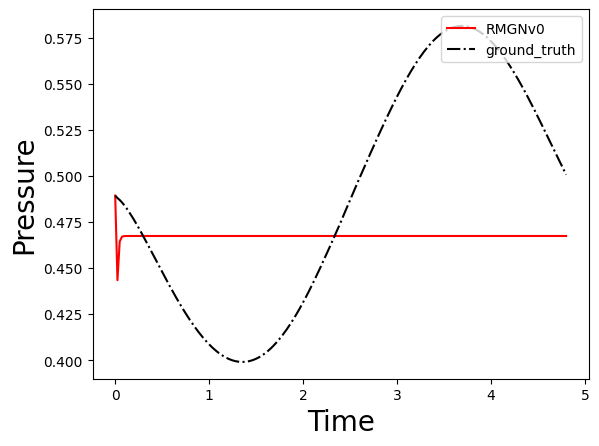

0

In [9]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(models, data, index, var_name = 'Pressure'):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    y_preds = []
    count = 0
    for model in models:
        total_loss = 0
        total_node_out = [data.pressure[:,0].unsqueeze(1)]
        total_edge_out = [data.velocity[:,0].unsqueeze(1)]
        for i in range(1, args.n_time):
            model.eval()
            with torch.no_grad():
                _pressure = data.pressure[:,i-1].unsqueeze(1)
                _velocity = data.velocity[:,i-1].unsqueeze(1)
                # if count == 0:
                #     x = torch.cat([_pressure], dim=1).to(args.device)
                # elif count == 1:
                x = torch.cat([_x, _pressure], dim=1).to(args.device)
        
                edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
                node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
                hidden = hidden.detach()

                total_node_out.append(node_out.detach().cpu())
                total_edge_out.append(edge_out.detach().cpu())
        total_node_out = torch.cat(total_node_out, dim=1)
        total_edge_out = torch.cat(total_edge_out, dim=1)
        if var_name == 'Pressure':
            y_preds.append(total_node_out[index].numpy())
        elif var_name == 'Velocity':
            y_preds.append(total_edge_out[index].numpy())

        count += 1
    
    color = ['red', 'green', 'blue', 'black']
    # plot
    if var_name == 'Pressure':
        y_true = data.pressure[index].numpy()
    elif var_name == 'Velocity':
        y_true = data.velocity[index].numpy()
    x = [i * 4.8 /200 for i in range(201)]
    for i in range(len(models)):
        plt.plot(x, y_preds[i], c=color[i], label='RMGNv'+str(i))
    plt.plot(x, y_true, c=color[-1], linestyle='dashdot', label='ground_truth')
    # plt.ylim([-50,50])
    plt.legend(loc='upper right')
    plt.ylabel(var_name, fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()
    
    return total_loss
    
# mean, std = mean_std_dataset(_dataset, set_id=list(range(_dataset.len())))
plot_comparison(models, dataset[40], index=50000, var_name='Pressure')